In [6]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## obtain data

In [2]:
# 下载数据集到本地
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
dataset_path = keras.utils.get_file("auto-mpg.data", url)

# 使用pandas 读取数据
column_names = ['MPG','气缸','排量','马力','重量','加速度', '年份', '产地']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()

# 打印dataset的前3条数据
dataset.head(3)

,MPG,气缸,排量,马力,重量,加速度,年份,产地
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1


## 清洗数据

In [3]:
dataset.isna().sum()

MPG    0
气缸     0
排量     0
马力     6
重量     0
加速度    0
年份     0
产地     0
dtype: int64

In [4]:
# 删除含有NA的数据行
dataset = dataset.dropna()

In [5]:
# 产地Origin转换成 one-hot编码
origin = dataset.pop("产地")
dataset['美国'] = (origin == 1) * 1.0
dataset['欧洲'] = (origin == 2) * 1.0
dataset['日本'] = (origin == 3) * 1.0

dataset.head(3)

,MPG,气缸,排量,马力,重量,加速度,年份,美国,欧洲,日本
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0


In [10]:
# 划分训练集80%、测试集20%
train_dataset, test_dateset = train_test_split(dataset, test_size=0.2)

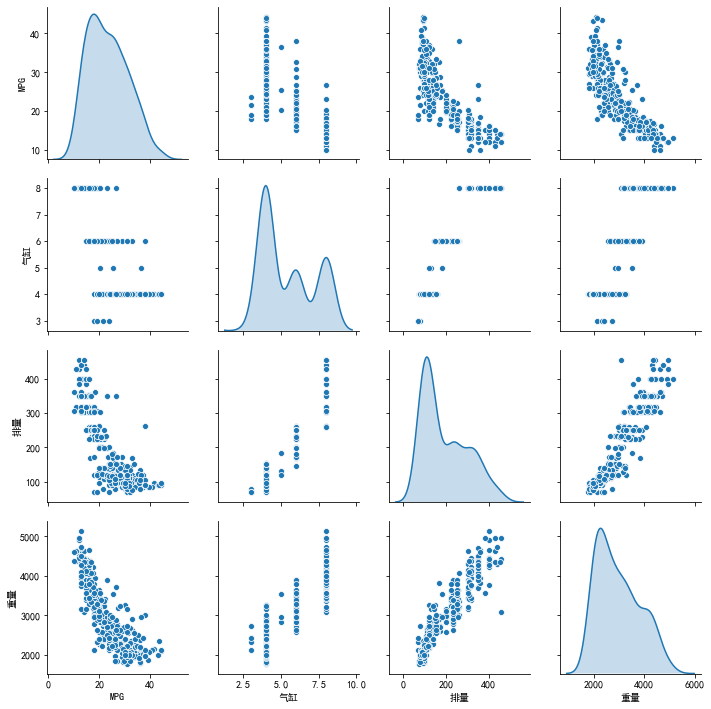

In [12]:
# 解决中文乱码问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
sns.pairplot(train_dataset[["MPG", "气缸", "排量", "重量"]], diag_kind="kde")

In [14]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
气缸,313.0,5.453674,1.703671,3.0,4.0,4.0,8.0,8.0
排量,313.0,195.214058,105.116520,70.0,105.0,146.0,262.0,455.0
马力,313.0,104.546326,38.956977,46.0,76.0,92.0,120.0,230.0
重量,313.0,2984.693291,837.148473,1773.0,2246.0,2833.0,3570.0,5140.0
加速度,313.0,15.565815,2.793309,8.5,13.5,15.5,17.3,24.8
年份,313.0,76.015974,3.730041,70.0,73.0,76.0,79.0,82.0
美国,313.0,0.629393,0.483741,0.0,0.0,1.0,1.0,1.0
欧洲,313.0,0.178914,0.383894,0.0,0.0,0.0,0.0,1.0
日本,313.0,0.191693,0.394263,0.0,0.0,0.0,0.0,1.0


## 分离label 作为监督模型label标签

In [15]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dateset.pop('MPG')

## 归一化数据

In [17]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dateset)

## build the model 

In [26]:
def build_model():
    input_dim = len(train_dataset.keys())
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[input_dim, ]),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss="mse", metrics=['mae', 'mse'],
                  optimizer=tf.keras.optimizers.RMSprop(0.001))
    return model

In [27]:
model = build_model()
# 打印模型信息
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


# 自定义训练进度条

In [28]:
import sys

EPOCHS = 1000

class ProgressBar(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs):
        # 显示进度条
        self.draw_progress_bar(epoch + 1, EPOCHS)
    
    def draw_progress_bar(self, cur, total, bar_len=50):
        cur_len = int(cur / total * bar_len)
        sys.stdout.write("\r")
        sys.stdout.write("[{:<{}}] {}/{}".format("=" * cur_len, bar_len, cur, total))
        sys.stdout.flush()

In [29]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                    validation_split=0.2, verbose=0, callbacks=[ProgressBar()])

[==================================================] 1000/1000

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [33]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('metric - MSE')
    plt.plot(hist['epoch'], hist['mse'], label='训练集')
    plt.plot(hist['epoch'], hist['val_mse'], label='验证集')
    plt.ylim([0, 20])
    plt.legend()
    
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('metric - MAE')
    plt.plot(hist['epoch'], hist['mae'], label='训练集')
    plt.plot(hist['epoch'], hist['val_mae'], label = '验证集')
    plt.ylim([0, 5])
    plt.legend()

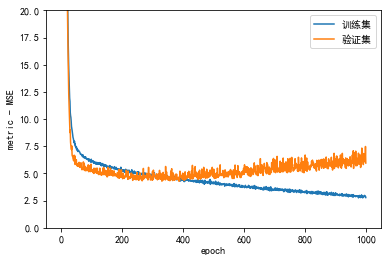

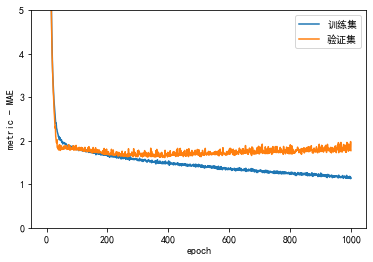

In [34]:
# 说明超过100epoch以后出现过拟合 需要调整一下训练的epoch次数
plot_history(history)

## 在训练过程中通过val_loss 不再下降的话 提前结束训练 

[====                                              ] 95/1000

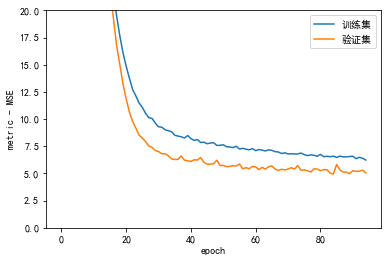

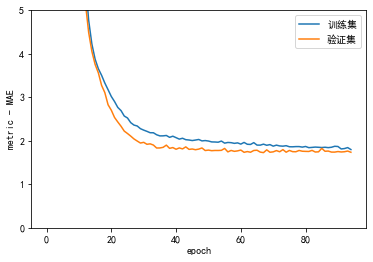

In [35]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                    validation_split=0.2, verbose=0, callbacks=[early_stop, ProgressBar()])
plot_history(history)

# evaluate the model

In [37]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("测试集平均绝对误差(MAE): {:5.2f} MPG".format(mae))
# 测试集平均绝对误差(MAE):  1.90 MPG

测试集平均绝对误差(MAE):  1.97 MPG


# predict the test data 

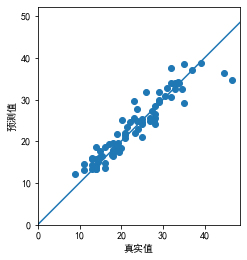

In [38]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_pred)
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])